# Binary Detection Template

## Imports

In [1]:
import os

import kornia
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from astropy.io import fits
from tqdm.notebook import tqdm
from torchvision import models
from typing import Tuple, List
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

## FLAGS

Change the following to {`True`, `False`} to enable or disable the execution of generating .csv dataset.

In [2]:
RECREATE_DATASET = True

## Data

### Generate CSV files

The following generates `.csv` files for training, validation and testing, based on `.fits` files placed in `binary` and `else` folders, and labels them `1` and `0`, respectively. 

In [3]:
def create_combined_csv(root_folder: str, output_folder: str, output_file: str = 'combined.csv'):
    """
    Creates a combined CSV file from .fits files in the given folders.
    
    Parameters:
    root_folder (str): The root folder containing the 'binary' and 'else' folders.
    output_folder (str): The folder where the CSV files will be saved.
    output_file (str): The name of the output combined CSV file.
    """
    # Define the subfolders and corresponding labels
    folders = {'binary': 1, 'else': 0}
    data = []

    # Iterate over the folders and files
    for folder, label in folders.items():
        folder_path = os.path.join(root_folder, folder)
        for file in os.listdir(folder_path):
            # Consider only FITS files
            if file.endswith('.fits'):
                # Save the absolute path, whith the corresponding label
                data.append({'path': os.path.abspath(os.path.join(folder_path, file)), 'label': label})

    # Create a DataFrame and save as CSV
    df = pd.DataFrame(data)
    os.makedirs(output_folder, exist_ok=True)
    df.to_csv(os.path.join(output_folder, output_file), index=False)


def stratified_split(input_df: pd.DataFrame,
                     train_size: int = 0.7,
                     test_size: int = 0.15,
                     random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Performs a stratified split on the input DataFrame.
    
    Parameters:
    input_df (DataFrame): The input DataFrame to be split.
    train_size (float): The proportion of the dataset to include in the train split.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): The seed used by the random number generator.
    
    Returns:
    tuple: A tuple containing the train, validation, and test DataFrames.
    """
    # Split the data into training and temporary (validation + test)
    train_df, temp_df = train_test_split(input_df, train_size=train_size, stratify=input_df['label'],
                                         random_state=random_state)

    # Split the temp data into validation and test
    val_size = test_size / (1 - train_size)
    val_df, test_df = train_test_split(temp_df, test_size=val_size, stratify=temp_df['label'],
                                       random_state=random_state)

    return train_df, val_df, test_df


def save_csv_files(dfs: List[pd.DataFrame],
                   output_folder: str,
                   filenames: List[str] = ['train.csv', 'valid.csv', 'test.csv']):
    """
    Saves given DataFrames as CSV files in the specified folder.
    
    Parameters:
    dfs (list of DataFrame): List of DataFrames to be saved.
    output_folder (str): The folder where the CSV files will be saved.
    filenames (list of str): Names of the output CSV files.
    """
    for df, filename in zip(dfs, filenames):
        df.to_csv(os.path.join(output_folder, filename), index=False)

Run the following lines only if there has been a change in the dataset, so you want to recreate the `.csv` files.
Once you have created the `.csv` files, you can set the `RECREATE_DATASET` flag to `False` so that it does not do it again.

In [4]:
root_folder = 'dataset'
output_folder = os.path.join('dataset', 'csv')

if RECREATE_DATASET:
    # Create combined CSV
    create_combined_csv(root_folder, output_folder)

    # Load the combined CSV
    combined_df = pd.read_csv(os.path.join(output_folder, 'combined.csv'))

    # Perform stratified split
    train_df, val_df, test_df = stratified_split(combined_df)

    # Save the split datasets
    save_csv_files([train_df, val_df, test_df], output_folder)

### Dataset and Data Augmentations

#### Define Custom Dataset

In [5]:
class FitsDataset(Dataset):
    """
    A custom PyTorch Dataset for handling .fits files.

    Args:
        csv_file (str): Path to the CSV file containing paths and labels.
        transform (callable, optional): Optional transform (data augmentation) to be applied on a sample.

    Attributes:
        data_frame (DataFrame): Pandas DataFrame containing the file paths and labels.
        transform (callable): Transform to be applied on a sample.
    """

    def __init__(self, csv_file: str, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        fits_path = self.data_frame.iloc[idx, 0]  # first column of .csv file
        label = self.data_frame.iloc[idx, 1]  # second column of .csv file

        with fits.open(fits_path) as hdul:
            image_data = hdul[0].data

        # Normalize the image data to [0,1]
        min_val = np.min(image_data)
        max_val = np.max(image_data)
        image_data = (image_data - min_val) / (max_val - min_val)
        image_data = image_data.astype(np.float32)
        
        # Create Tensor
        image_data = torch.from_numpy(image_data)
        # add channel dimension
        image_data = image_data.unsqueeze(0)
        
        # Apply data augmentation if defined
        if self.transform:
            image_data = self.transform(image_data)

        # Center crop to size
        image_data = transforms.functional.center_crop(image_data, output_size=(224, 224))
        
        return image_data, label

#### Define Data Augmentation Pipeline

In [6]:
class CustomTransform:
    def __init__(self, p=0.5):
        self.p = p
        self.angles = [0, 90, 180, 270]
        self.translation_values = [-1, 0, 1]

    def __call__(self, input_data):

        # Random horizontal flip with probability p
        if random.random() < self.p:
            input_data = torch.flip(input_data, [-1])

        # Random vertical flip with probability p
        if random.random() < self.p:
            input_data = torch.flip(input_data, [-2])

        # Random translation with one of the values
        trans_x = random.choice(self.translation_values)
        trans_y = random.choice(self.translation_values)
        translation_value = torch.tensor([[trans_x, trans_y]], dtype=torch.float32)
        input_data = kornia.geometry.transform.translate(input_data, translation_value, mode='nearest')

        # Random rotation with one of the angles
        angle = random.choice(self.angles)
        angle = torch.tensor(angle, dtype=torch.float32)
        # # Add batch dimension
        # input_data = input_data.unsqueeze(0)
        input_data = kornia.geometry.transform.rotate(input_data, angle, mode='bicubic')

        return input_data

#### Let's visualize the training samples

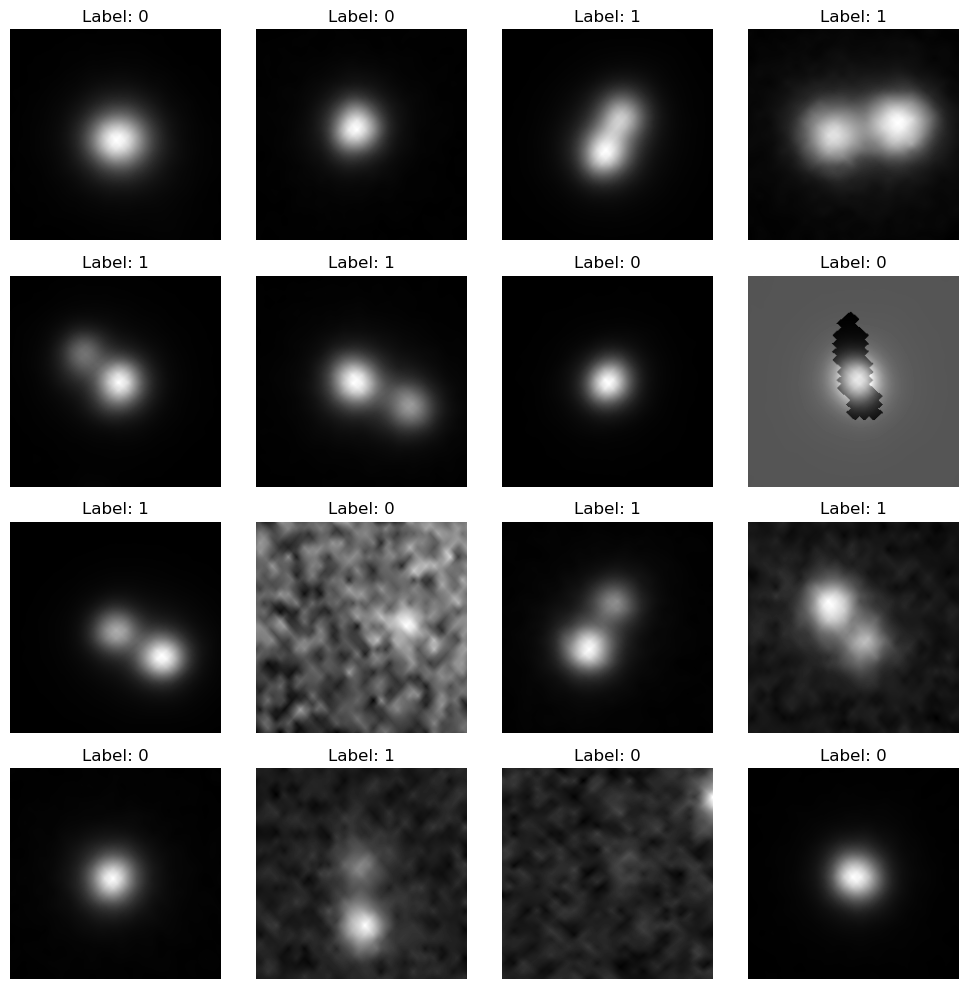

In [7]:
train_csv = os.path.join('dataset', 'csv', 'train.csv')
valid_csv = os.path.join('dataset', 'csv', 'valid.csv')

custom_transform = CustomTransform(p=0.5)

train_dataset = FitsDataset(train_csv, custom_transform)
valid_dataset = FitsDataset(valid_csv)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# Fetch the first batch
first_batch_images, first_batch_labels = next(iter(train_loader))

# Create a 4x4 grid for subplot
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Flatten the array of axes for easy iteration
axs = axs.ravel()

for i in range(16):
    # Plot each image in its respective subplot
    axs[i].imshow(first_batch_images[i].squeeze(), cmap='gray')
    axs[i].set_title(f"Label: {first_batch_labels[i]}")
    axs[i].axis('off')  # Turn off axis to make the plot cleaner

plt.tight_layout()
plt.show()

## Training

### Setup

In [8]:
# Load ResNet model without pre-trained weights
model = models.resnet34(pretrained=False)
# Change input channels from 3 to 1
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Change output channels to 2 (binary classification)
model.fc = nn.Linear(model.fc.in_features, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.05)

# Save the best model to this path
best_model_path = os.path.join("trained_models")
os.makedirs(best_model_path, exist_ok=True)
best_model = os.path.join(best_model_path, f'best_model.pth')

# Check if GPU is available and move the model to GPU if it is
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

num_epochs = 40  # Number of training epochs

/media/medimadi/Data/miniconda3/envs/work/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/medimadi/Data/miniconda3/envs/work/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


cuda:0


### Training and Validation Loops

In [9]:
# training the model
best_f1 = 0.0
for epoch in tqdm(range(num_epochs), desc='Epochs'):
    model.train()
    train_preds, train_targets = [], []
    train_losses = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())
        train_losses.append(loss.item())

    train_f1 = f1_score(train_targets, train_preds, average='weighted')

    model.eval()
    valid_preds, valid_targets = [], []
    valid_losses = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)
            valid_preds.extend(preds.cpu().numpy())
            valid_targets.extend(labels.cpu().numpy())

            loss = criterion(outputs, labels)
            valid_losses.append(loss.item())

    valid_f1 = f1_score(valid_targets, valid_preds, average='weighted')

    if valid_f1 >= best_f1:
        best_f1 = valid_f1
        torch.save(model.state_dict(), best_model)

    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Train F1: {train_f1:.4f}, Valid F1: {valid_f1:.4f}')

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Train F1: 0.5200, Valid F1: 0.3370
Epoch 2/40, Train F1: 0.7594, Valid F1: 0.3541
Epoch 3/40, Train F1: 0.8080, Valid F1: 0.3541
Epoch 4/40, Train F1: 0.9360, Valid F1: 0.3541
Epoch 5/40, Train F1: 0.8878, Valid F1: 0.3541
Epoch 6/40, Train F1: 0.9280, Valid F1: 0.3541
Epoch 7/40, Train F1: 0.8960, Valid F1: 0.4317
Epoch 8/40, Train F1: 0.8637, Valid F1: 0.6386
Epoch 9/40, Train F1: 0.9199, Valid F1: 0.7250
Epoch 10/40, Train F1: 0.9200, Valid F1: 0.4591
Epoch 11/40, Train F1: 0.9840, Valid F1: 0.8519
Epoch 12/40, Train F1: 0.9760, Valid F1: 0.8494
Epoch 13/40, Train F1: 0.9520, Valid F1: 1.0000
Epoch 14/40, Train F1: 0.9440, Valid F1: 0.4317
Epoch 15/40, Train F1: 0.9600, Valid F1: 0.3541
Epoch 16/40, Train F1: 0.9680, Valid F1: 0.8117
Epoch 17/40, Train F1: 0.9920, Valid F1: 0.8886
Epoch 18/40, Train F1: 0.9680, Valid F1: 0.9629
Epoch 19/40, Train F1: 0.9840, Valid F1: 0.8870
Epoch 20/40, Train F1: 0.9840, Valid F1: 0.8870
Epoch 21/40, Train F1: 0.9840, Valid F1: 1.0000
E

## Let's test our trained model!

### Define test dataset

In [10]:
test_csv = os.path.join('dataset', 'csv', 'test.csv')
test_dataset = FitsDataset(test_csv)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Load the best trained model

In [11]:
# Load the best model
model.load_state_dict(torch.load(best_model))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Let's see how it works on unseen data

In [12]:
test_preds, test_targets = [], []
test_losses = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

# Generate a classification report
print("\nDetailed Classification Report:")
print(classification_report(test_targets, test_preds))


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        14
           1       0.92      0.86      0.89        14

    accuracy                           0.89        28
   macro avg       0.89      0.89      0.89        28
weighted avg       0.89      0.89      0.89        28

